<a href="https://colab.research.google.com/github/Ssouh/EuroMoneyRecognition/blob/main/Projet_EuroMoneyRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification d'images de chiens et de chats

Dans ce TP, on s'intéresse au problème simple (en apparence) de reconnaître des chiens et des chats dans des images.

<center> <img src="https://drive.google.com/uc?id=11W1SmzrBhL8vyzPCjSkZfHWnxb7kByi5" style="width:1000;height:550px;"></center>
<caption><center><b> Figure 1 : Quelques images de la base de données </b></center></caption>

Pour cela nous allons utiliser une base de données de 4000 images, réparties en 2000 images d'apprentissage, 1000 images de validation, et 1000 images de test. Compte-tenu de la variabilité possible des représentations de chiens et chats, cette base de données est d'une taille assez réduite et le problème est complexe. Il correspond bien aux problèmes que nous pouvons rencontrer dans la réalité, lorsque les données sont souvent difficiles à obtenir.


In [2]:
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline


## Chargement des données
La base de données est à télécharger depuis Git. Ne passez pas trop de temps à regarder les cellules suivantes (mais exécutez les !), en revanche elles vous fournissent un bon exemple de code pour charger vos propres datasets, **ce qui vous sera utile pour le projet !**

In [3]:
!git clone https://github.com/Testoxe/EuroMoneyRecognition.git
path = "./data/"

fatal: destination path 'EuroMoneyRecognition' already exists and is not an empty directory.


Création de listes contenant les noms des images des ensemble d'apprentissage, de validation et de test, ainsi que les label (0: chat, 1:chien) associés

In [ ]:
import os
import shutil

#Images d'entrainement
train_filenames_dogs= os.listdir(path + "training/dogs")
train_filenames_cats= os.listdir(path + "training/cats")
if not os.path.exists(path + "training/training"):
  os.mkdir(path + "training/training")

path_train = path + "training/"
for filename in train_filenames_cats:
  shutil.copyfile(path_train+"cats/"+filename, path_train+"training/"+filename)
for filename in train_filenames_dogs:
  shutil.copyfile(path_train+"dogs/"+filename, path_train+"training/"+filename)

train_filenames = os.listdir(path + "training/training")
train_categories=[]
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        train_categories.append(1)
    else:
        train_categories.append(0)

#Images de validation
validation_filenames = os.listdir(path +"validation/")
validation_categories=[]
for filename in validation_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        validation_categories.append(1)
    else:
        validation_categories.append(0)

#Images de test
test_filenames = os.listdir(path + "test/")
test_categories=[]
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        test_categories.append(1)
    else:
        test_categories.append(0)

Création de DataFrames (structure de données qui permettra plus loins de charger les données au fur et à mesure des besoins)


In [ ]:
#Images d'entrainement
train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})


#Images de validation
validation_df = pd.DataFrame({
    'filename': validation_filenames,
    'category': validation_categories
})


#Images de test
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


train_df['category'] = train_df['category'].astype(str)
validation_df['category'] = validation_df['category'].astype(str)
test_df['category'] = validation_df['category'].astype(str)

total_train = train_df.shape[0]
total_validate = validation_df.shape[0]

### Visualisation des images

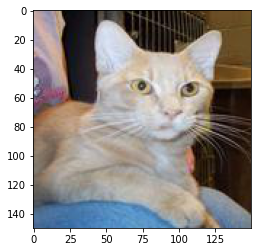

In [ ]:
import random
from keras.preprocessing.image import load_img

sample = random.choice(test_filenames)
image = load_img(path + "test/" +sample)
plt.imshow(image)
plt.show()

### Prétraitement des images

La syntaxe ci-dessous définit pour chaque ensemble de données des "generator" qui permettent de charger un nombre prédéfini d'images (ce sera notre taille de batch) à partir des DataFrame définies précédemment. On définit également une dimension cible des images (ici, 150x150) et un pré-traitement de normalisation (division par 255).

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16
image_size = 150


#Images d'entrainement
train_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path + "train/train/",
    x_col='filename',
    y_col='category',
    target_size=(image_size,image_size),
    class_mode='binary',
    batch_size=batch_size
)

#Images de validation
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    path + "validation/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

#Images de test
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    path + "test/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
labels= {0: 'Chat', 1: 'Chien'}
labels.get(0), labels.get(1)

('Chat', 'Chien')

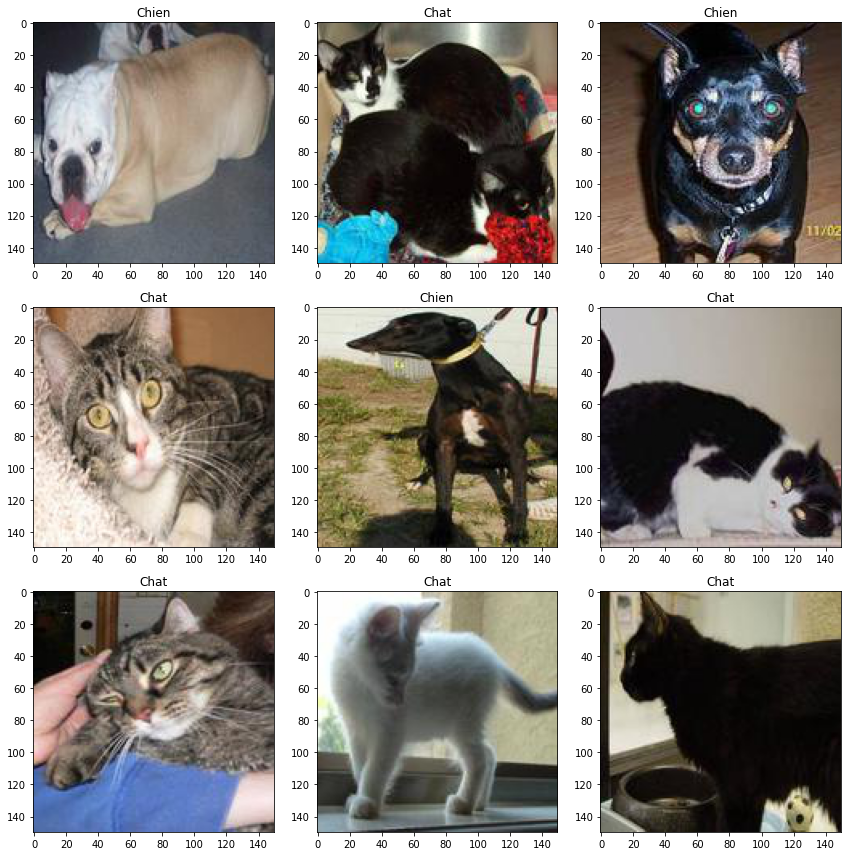

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.title(labels.get(Y_batch[0]))
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Première approche : réseau convolutif de base

Les images ont toutes été redimensionnées en $150\times150$. Nous pouvons donc définir notre réseau de neurones convolutif en suivant ce schéma : 

<center> <img src="https://drive.google.com/uc?id=1bwXaIgO-pKJGs6fVaX0IrLbFbUAlTvNM" style="width:800;height:400px;"></center>
<caption><center><b> Figure 2: Vue de l'architecture à implémenter </b></center></caption>

Ce réseau alterne dans une première phase les couches de convolution et de Max Pooling (afin de diviser à chaque fois la dimension des tenseurs par 2). 

La première couche comptera 32 filtres de convolution, la seconde 64, la troisième 96 et la 4e 128. Enfin, avant la couche de sortie, vous ajouterez une couche dense comptant 512 neurones. Vous aurez donc construit un réseau à 6 couches, sorte de version simplifiée d'AlexNet.

Pour construire ce réseau, vous pouvez utiliser les fonctions Conv2D, Maxpooling2D, et Flatten de Keras.

In [ ]:
#model = models.Sequential()
# model.add(Conv2D(...))
# model.add(MaxPooling2D(..))
# ...
# model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
# model.add(Dense(...))   # Couche dense, à 512 neurones
# model.add(Dense(...))   # Couche de sortie
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(150,150,3),padding='same'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(96, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))               
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       1

### Entrainement

Pour l'entraînement, vous pouvez utiliser directement les hyperparamètres suivants.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

... puis lancer l'entraînement. **Attention : si jamais vous voulez relancer l'entraînement, il faut réinitialiser les poids du réseau. Pour cela il faut re-exécuter les cellules précédentes à partir de la définition du réseau !** Sinon vous risquez de repartir d'un entraînement précédent (qui s'est éventuellement bien, ou mal déroulé) et mal interpréter votre nouvel entraînement.

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
125/125 [==============================] - 35s 28ms/step - loss: 0.7007 - acc: 0.4972 - val_loss: 0.6753 - val_acc: 0.5360
Epoch 2/10
125/125 [==============================] - 3s 24ms/step - loss: 0.6600 - acc: 0.6138 - val_loss: 0.6553 - val_acc: 0.5880
Epoch 3/10
125/125 [==============================] - 3s 24ms/step - loss: 0.6154 - acc: 0.6647 - val_loss: 0.6146 - val_acc: 0.6810
Epoch 4/10
125/125 [==============================] - 3s 24ms/step - loss: 0.5535 - acc: 0.7434 - val_loss: 0.5784 - val_acc: 0.7130
Epoch 5/10
125/125 [==============================] - 3s 24ms/step - loss: 0.5145 - acc: 0.7742 - val_loss: 0.5953 - val_acc: 0.6950
Epoch 6/10
125/125 [==============================] - 3s 23ms/step - loss: 0.5068 - acc: 0.7615 - val_loss: 0.5866 - val_acc: 0.7000
Epoch 7/10
125/125 [==============================] - 3s 24ms/step - loss: 0.4775 - acc: 0.7769 - val_loss: 0.5745 - val_acc: 0.7290
Epoch 8/10
125/125 [==============================] - 3s 23ms/step -

### Analyse des résultats du modèle

Les quelques lignes suivantes permettent d'afficher l'évolution des métriques au cours de l'entraînement, sur les ensembles d'apprentissage et de validation.

In [ ]:
def plot_training_analysis():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

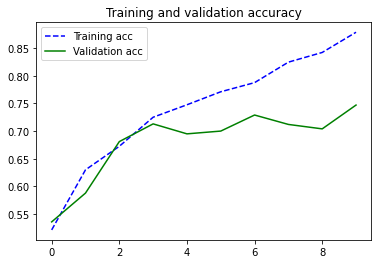

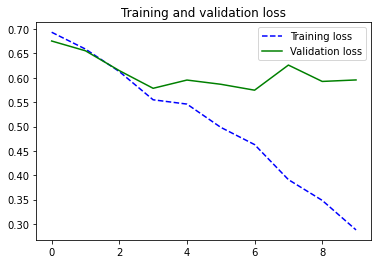

In [ ]:
plot_training_analysis()

### Correction du surapprentissage

Vous devriez maintenant reconnaître le problème auquel vous avez affaire : **le surapprentissage**. Ce problème est classique dès lors que l'on travaille sur des bases de données de taille réduite en apprentissage profond.
 En effet, le réseau que vous avez créé compte normalement (si vous avez suivi les indications) plus de trois millions de paramètres. Le problème que vous essayez de résoudre pendant l'entraînement consiste à établir 3 millions de paramètres avec seulement 2000 exemples : c'est trop peu !

Afin de limiter ce surapprentissage, nous pouvons appliquer les techniques de régularisation vues pendant le 2nd cours. En traitement d'image, une des techniques les plus couramment utilisées est **l'augmentation de la base de données**.

Nous allons reprendre l'ImageDataGenerator créé précédemment pour normaliser les images et l'utiliser  pour appliquer des transformations supplémentaires aux images de notre base de données. A vous de chercher dans la documentation à quoi correspondent les différents paramètres présentés ci-dessous.

In [ ]:
train_datagen_2 = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator_augmented = train_datagen_2.flow_from_dataframe(
    train_df, 
    path + 'train/train/',
    x_col='filename',
    y_col='category',
    target_size=(image_size,image_size),
    class_mode='binary',
    batch_size=batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


La cellule suivante vous permet de visualiser des images passées à travers notre boucle d'augmentation de données. Observez comment les valeurs manquantes (par exemple, dans le cas d'une rotation) sont comblées.

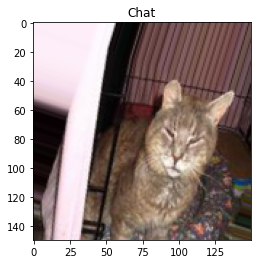

In [ ]:
example_x, example_y = train_generator_augmented.next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(labels.get(example_y[i]))
    plt.show()

Nous pouvons maintenant recréer notre modèle et relancer l'entraînement.

In [ ]:
model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(150,150,3),padding='same'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(96, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))               
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=50,
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 96)        55392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 128)      

### Analyse des résultats

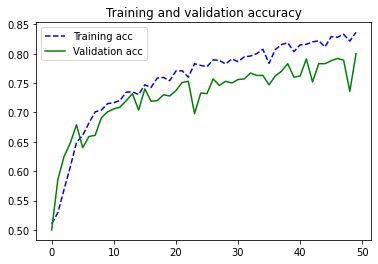

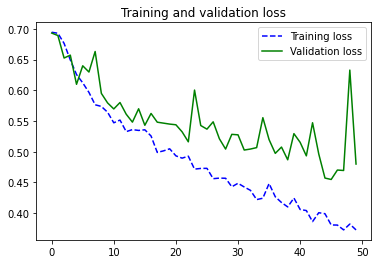

In [ ]:
plot_training_analysis()

On voit clairement sur les courbes que l'on a limité le sur-apprentissage. Notez aussi d'ailleurs, et c'est important, que l'apprentissage est plus lent : le modèle met plus de temps à prédire correctement l'ensemble d'apprentissage. C'est normal, car on a en quelque sorte "complexifié le problème" en introduisant toutes ces déformations de nos images.
Cette forme de régularisation "par les données" s'ajoute aux autres méthodes que nous avons vues précédemment comme la régularisation L1/L2 des poids du réseau et le Dropout.  

Vous devriez maintenant atteindre des performances autour de 80% de précision sur l'ensemble de validation, ce qui est bien mais pas complètement satisfaisant : il faudrait pour continuer à s'améliorer probablement s'entraîner plus longtemps, mais également disposer de plus de données.

Une autre solution est d'utiliser le **Transfer Learning**.

# Transfer learning

L'une des raisons qui peut expliquer le fait que nos résultats soient décevants est que les premières couches de notre réseau convolutif, sensées détecter des caractéristiques utiles pour discriminer chiens et chats, n'ont pas appris de filtres suffisamment généraux à partir des 2000 images d'entraînement. Ainsi, même si ces filtres sont pertinents pour les 2000 images d'entraînement, il y a en fait assez peu de chances que ces filtres puissent bien fonctionner pour la généralisation sur de nouvelles données.

C'est la raison pour laquelle nous avons envie de réutiliser un réseau pré-entrainé sur une large base de données, permettant donc de détecter des caractéristiques qui généraliseront mieux à de nouvelles données.

Dans cette partie, nous allons réutiliser un réseau célèbre, et d'ores et déjà entraîné sur la base de données ImageNet : le réseau VGG-16.

Commençons par récupérer les couches de convolution de ce réseau, et s'en remémorer  la composition.

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Nous pouvons extraire les caractéristiques, apprises par le réseau de neurones sur ImageNet, de notre base de données d'image de chiens et de chat. L'intérêt, par rapport à la première partie, est qu'il aurait été presque impossible de déduire ces caractéristiques "générales" (trouvées sur une immense base de données) depuis notre base de données trop réduite de 2000 images. En revanche, ces caractéristiques générales devraient se révéler utiles pour notre classifieur.

On peut lire sur la structure du réseau VGG résumée grâce à la fonction *summary* ci-dessus que le tenseur de sortie est de dimension $4 \times 4 \times 512$, autrement dit que le réseau prédit des caractéristiques de dimension $4 \times 4 \times 512$ à partir d'une image de taille $150 \times 150$.

On va redimensionner cette sortie dans un vecteur de dimension $8192 = 4 \times 4 \times 512$. 

In [ ]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0],4*4*512))

val_features = conv_base.predict(validation_generator)
val_features = np.reshape(val_features,(val_features.shape[0],4*4*512))

Il nous faut également récupérer les labels associés ; nous allons les chercher dans la dataframe définie au début du TP.

In [ ]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = validation_df.to_numpy()
y_val = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

Nous pouvons maintenant définir un réseau de neurones simple qui va travailler directement sur les caractéristiques prédites par VGG.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5)) # On utilise du DropOut sur cette couche dense car elle comporte un grand nombre
                               # de paramètres et risque d'être très sujette au sur-apprentissage.
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.8900 - acc: 0.5017 - val_loss: 0.6984 - val_acc: 0.5030
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6835 - acc: 0.5386 - val_loss: 0.7298 - val_acc: 0.4880
Epoch 3/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6844 - acc: 0.5524 - val_loss: 0.7131 - val_acc: 0.5060
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6494 - acc: 0.6206 - val_loss: 0.7079 - val_acc: 0.4960
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6228 - acc: 0.6584 - val_loss: 0.7187 - val_acc: 0.4730
Epoch 6/50
125/125 [==============================] - 0s 4ms/step - loss: 0.6053 - acc: 0.6622 - val_loss: 0.7306 - val_acc: 0.4820
Epoch 7/50
125/125 [==============================] - 0s 3ms/step - loss: 0.5514 - acc: 0.7259 - val_loss: 0.7526 - val_acc: 0.4870
Epoch 8/50
125/125 [==============================] - 0s 3ms/step - loss: 0.

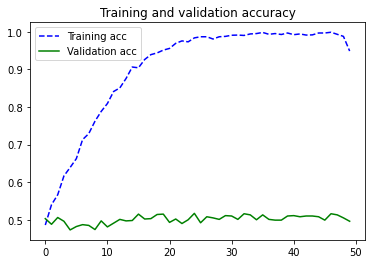

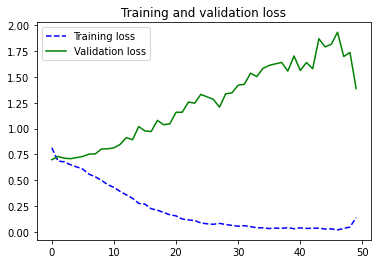

In [ ]:
plot_training_analysis()

On observe à nouveau beaucoup de sur-apprentissage. Il faudrait trouver un moyen d'intégrer de l'augmentation de données. 

Pour cela, on peut connecter notre petit réseau de neurones à l'extrémité de la base convolutionnelle de VGG. L'idée est qu'en réutilisant notre générateur de données augmentées, nous pourrons calculer les caractéristiques de VGG sur les données augmentées, et ainsi classifier ces caractéristiques plutôt que les caractéristiques de notre base de données uniquement.

## Intégration de l'augmentation de données

### Définition du nouveau modèle et entrainement

On commence par créer un nouveau modèle qui va s'appuyer sur la base convolutive de VGG, à laquelle on adjoint une couche dense et notre couche de sortie.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


**Attention** : il est important de ne pas commander l'entraînement de la base convolutionnelle de VGG ! Nous ne voulons en aucun cas écraser les bonnes caractéristiques de VGG que nous cherchons justement à réutiliser ! Le réseau aurait en outre un grand nombre de paramètres, ce qui est justement ce que l'on veut éviter ! 

Pour cela nous pouvons utiliser l'attribut *trainable* : en le positionnant à *false*, nous pouvons geler les poids et en empêcher la mise à jour pendant l'entraînement.

In [ ]:
conv_base.trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Observez le décompte des poids : le nombre de poids entraînable est maintenant à 2 millions, contre 16 millions précédemment ; on ne va entrainer ici que les poids de notre couche dense et de la couche de sortie.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history = model.fit(
    train_generator_augmented,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
125/125 [==============================] - 14s 103ms/step - loss: 0.5388 - acc: 0.7194 - val_loss: 0.2842 - val_acc: 0.8730
Epoch 2/10
125/125 [==============================] - 13s 100ms/step - loss: 0.4383 - acc: 0.8067 - val_loss: 0.2806 - val_acc: 0.8770
Epoch 3/10
125/125 [==============================] - 12s 100ms/step - loss: 0.3622 - acc: 0.8455 - val_loss: 0.2750 - val_acc: 0.8860
Epoch 4/10
125/125 [==============================] - 13s 101ms/step - loss: 0.3741 - acc: 0.8398 - val_loss: 0.2881 - val_acc: 0.8720
Epoch 5/10
125/125 [==============================] - 12s 99ms/step - loss: 0.3308 - acc: 0.8519 - val_loss: 0.2513 - val_acc: 0.8900
Epoch 6/10
125/125 [==============================] - 12s 99ms/step - loss: 0.3092 - acc: 0.8559 - val_loss: 0.2465 - val_acc: 0.8990
Epoch 7/10
125/125 [==============================] - 12s 100ms/step - loss: 0.3096 - acc: 0.8660 - val_loss: 0.2934 - val_acc: 0.8750
Epoch 8/10
125/125 [==============================] - 12s

### Analyse des résultats du nouveau modèle

L'entraînement est beaucoup plus lent ! Il faut en effet générer les données augmentées, et leur faire traverser les couches de VGG à chaque itération de gradient. Ceci prend du temps !

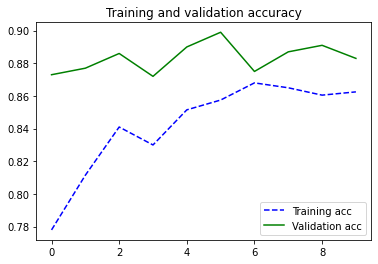

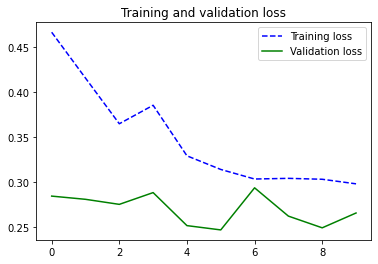

In [ ]:
plot_training_analysis()

En revanche, on observe que l'on a bien limité le sur-apprentissage, ce qui était le but recherché. Cela améliore considérablement les résultats !

### Fine-tuning


Nous pouvons maintenant tester la dernière technique vue en cours : le **fine-tuning**. Pour cela, nous allons repartir du réseau que nous venons d'entraîner, mais nous allons débloquer l'entraînement des poids de l'ensemble du réseau. **ATTENTION : il est important de choisir un taux d'apprentissage très faible afin de ne pas réduire à néant les bénéfices des entraînements précédents.** L'objectif est simplement de faire évoluer les paramètres du réseau "à la marge", et ceci ne peut être fait qu'après la première étape de *transfer learning* précédente. Sans cela, les dernières couches ajoutées à la suite de la base convolutive, après leur initialisation aléatoire, auraient engendré de forts gradients qui auraient complètement détruit les filtres généraux de VGG.



On commence par réactiver l'entraînement des paramètres de la base convolutive de VGG : 

In [ ]:
conv_base.trainable = True
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['acc'])

history = model.fit(
    train_generator_augmented,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
125/125 [==============================] - 15s 106ms/step - loss: 0.3079 - acc: 0.8636 - val_loss: 0.1587 - val_acc: 0.9300
Epoch 2/10
125/125 [==============================] - 13s 104ms/step - loss: 0.1826 - acc: 0.9204 - val_loss: 0.1435 - val_acc: 0.9420
Epoch 3/10
125/125 [==============================] - 13s 104ms/step - loss: 0.1598 - acc: 0.9346 - val_loss: 0.2182 - val_acc: 0.9270
Epoch 4/10
125/125 [==============================] - 13s 104ms/step - loss: 0.1531 - acc: 0.9404 - val_loss: 0.1224 - val_acc: 0.9610
Epoch 5/10
125/125 [==============================] - 13s 104ms/step - loss: 0.1129 - acc: 0.9473 - val_loss: 0.1298 - val_acc: 0.9500
Epoch 6/10
125/125 [==============================] - 13s 105ms/step - loss: 0.0868 - acc: 0.9649 - val_loss: 0.1038 - val_acc: 0.9600
Epoch 7/10
125/125 [==============================] - 13s 105ms/step - loss: 0.0867 - acc: 0.9643 - val_loss: 0.1269 - val_acc: 0.9520
Epoch 8/10
125/125 [==============================] - 1

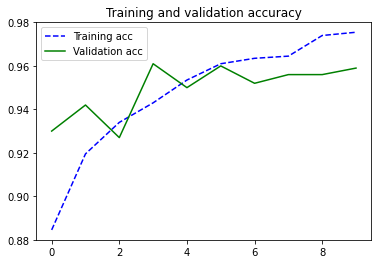

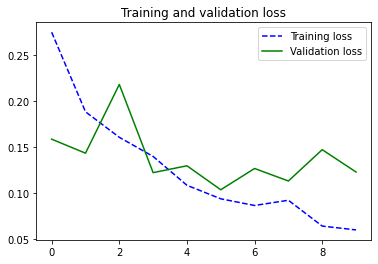

In [ ]:
plot_training_analysis()

On atteint l'excellent résultat de 97% de précision sur l'ensemble de validation, bien au-dessus des performances obtenues sans *transfer learning* ! Vous comprenez maintenant pourquoi en traitement d'image, cette technique est incontournable.

**Questions (si vous avez du temps, et qui vous serviront pour le projet)** :



*   En réalité, on utilise plus vraiment la couche Flatten() aujourd'hui pour faire le lien entre couches convolutives et couches denses, mais plutôt une couche de [GlobalAveragePooling()](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/). Essayez de comprendre ce que fait cette couche et de modifier le réseau construit par dessus VGG en conséquence. 
*   Essayez de charger d'autres modèles que VGG16 au début de ce TP. Vous trouverez sur la doc de Keras [une liste des modèles utilisables](https://keras.io/api/applications/). Vous pouvez par exemple tester des réseaux plus avancés, que nous verrons dans la suite du cours, comme par exemple Inception et ResNet. Quel réseau fournit les meilleurs résultats ? (Attention à bien lire la documentation, certains réseaux comme EfficientNet prennent en entrée des images non normalisées, ce qui nécessite des modifications dans l'ImageDataGenerator défini plus haut).

